In [107]:
%matplotlib inline

import pandas as pd
import numpy as np

from dash import Dash, html, dcc
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=False)

from typing import *

app = Dash(__name__)

PLOTLY_THEME = "plotly_white"
EXPORT_DIR = "image_out"
MAIN_DATA = "data.csv"

import os

if not os.path.exists(EXPORT_DIR):
    os.mkdir(EXPORT_DIR)

# Load Datasets

In [108]:
if not os.path.exists(MAIN_DATA):
    # Auto download from pre-computed Nextcloud server
    import requests
    r = requests.get("https://next.jmw.nz/s/L7drTr5wLqs67Te/download")
    with open(MAIN_DATA, "wb") as f:
        f.write(r.content)

In [109]:
power_sources = pd.read_csv("power_sources.csv", header=None)
power_sources.columns = ["source_id","source","ci-co2-per-kwh"]
power_sources

source_id      source  ci-co2-per-kwh
0          1     battery               8
1          2      co_gen             249
2          3         gas             410
3          4        coal            1073
4          5       hydro               8
5          6  geothermal              90
6          8        wind               7
7          7      diesel             850

In [110]:
data_raw = pd.read_csv("data.csv", index_col=0)

# Convert reading_timestamp to datetime
data_raw["reading_timestamp"] = pd.to_datetime(data_raw["reading_timestamp"])

data_raw.loc[data_raw["source_id"]==5].tail(16)

source_id  generation  capacity         reading_timestamp
id                                                              
81676          5        3182      5415 2023-04-20 19:00:00+00:00
81684          5        3493      5415 2023-04-20 19:30:00+00:00
81692          5        3695      5415 2023-04-20 20:00:00+00:00
81700          5        3785      5415 2023-04-20 20:30:00+00:00
81708          5        3837      5415 2023-04-20 21:00:00+00:00
81716          5        3803      5415 2023-04-20 21:30:00+00:00
81724          5        3747      5415 2023-04-20 22:00:00+00:00
81732          5        3736      5415 2023-04-20 22:30:00+00:00
81740          5        3724      5415 2023-04-20 23:00:00+00:00
81748          5        3681      5415 2023-04-20 23:30:00+00:00
81756          5        3701      5415 2023-04-21 00:00:00+00:00
81764          5        3682      5415 2023-04-21 00:30:00+00:00
81772          5        3663      5415 2023-04-21 01:00:00+00:00
81780          5        3631      5415 2023-04-21 01:30:00+00:00
81788          5        3624      5415 2023-04-21 02:00:00+00:00
51575          5        3554      5415 2023-01-19 05:00:00+00:00

In [111]:
data_raw = data_raw.merge(power_sources)
data_raw

source_id  generation  capacity         reading_timestamp   source  \
0              1           0         1 2022-08-20 02:30:00+00:00  battery   
1              1           0         1 2022-08-20 03:00:00+00:00  battery   
2              1           0         1 2022-08-20 03:30:00+00:00  battery   
3              1           0         1 2022-08-20 04:00:00+00:00  battery   
4              1           0         1 2022-08-20 04:30:00+00:00  battery   
...          ...         ...       ...                       ...      ...   
81627          8          52      1040 2023-04-21 00:30:00+00:00     wind   
81628          8          60      1040 2023-04-21 01:00:00+00:00     wind   
81629          8          57      1040 2023-04-21 01:30:00+00:00     wind   
81630          8          48      1040 2023-04-21 02:00:00+00:00     wind   
81631          8         102      1040 2023-01-19 05:00:00+00:00     wind   

       ci-co2-per-kwh  
0                   8  
1                   8  
2                   8  
3                   8  
4                   8  
...               ...  
81627               7  
81628               7  
81629               7  
81630               7  
81631               7  

[81632 rows x 6 columns]

In [112]:
# Flatten data structure, it now has 16 columns
# 	id	source_id	generation	capacity	reading_timestamp\
# Transform so each of the 8 source_id's are in their own column with their generation and capacity
# Group the source ID's by their reading timestamp
generation_logs = data_raw.pivot_table(index=["reading_timestamp"], columns="source", values=["generation","ci-co2-per-kwh"]).reset_index()
generation_logs

reading_timestamp ci-co2-per-kwh                           \
source                                  battery co_gen  coal diesel  gas   
0      2022-08-20 02:00:00+00:00              8    249  1073    850  410   
1      2022-08-20 02:30:00+00:00              8    249  1073    850  410   
2      2022-08-20 03:00:00+00:00              8    249  1073    850  410   
3      2022-08-20 03:30:00+00:00              8    249  1073    850  410   
4      2022-08-20 04:00:00+00:00              8    249  1073    850  410   
...                          ...            ...    ...   ...    ...  ...   
10199  2023-04-21 00:00:00+00:00              8    249  1073    850  410   
10200  2023-04-21 00:30:00+00:00              8    249  1073    850  410   
10201  2023-04-21 01:00:00+00:00              8    249  1073    850  410   
10202  2023-04-21 01:30:00+00:00              8    249  1073    850  410   
10203  2023-04-21 02:00:00+00:00              8    249  1073    850  410   

                             generation                                     \
source geothermal hydro wind    battery co_gen coal diesel  gas geothermal   
0              90     8    7          0    109    0      0  201        923   
1              90     8    7          0     99    0      0  202        924   
2              90     8    7          0     87    0      0  221        923   
3              90     8    7          0     86    0      0  221        924   
4              90     8    7          0    101    0      0  251        924   
...           ...   ...  ...        ...    ...  ...    ...  ...        ...   
10199          90     8    7          0     95  178      0  434        782   
10200          90     8    7          0     93  178      0  432        784   
10201          90     8    7          0     94  164      0  432        783   
10202          90     8    7          0     96  160      0  427        783   
10203          90     8    7          0     94  158      0  431        785   

                   
source hydro wind  
0       2783  616  
1       2829  567  
2       2899  531  
3       2926  537  
4       2942  536  
...      ...  ...  
10199   3701   58  
10200   3682   52  
10201   3663   60  
10202   3631   57  
10203   3624   48  

[10204 rows x 17 columns]

# Scan for issues in Dataset

In [113]:
# Check for partial rows
generation_logs[generation_logs.isnull().any(axis=1)]


Empty DataFrame
Columns: [(reading_timestamp, ), (ci-co2-per-kwh, battery), (ci-co2-per-kwh, co_gen), (ci-co2-per-kwh, coal), (ci-co2-per-kwh, diesel), (ci-co2-per-kwh, gas), (ci-co2-per-kwh, geothermal), (ci-co2-per-kwh, hydro), (ci-co2-per-kwh, wind), (generation, battery), (generation, co_gen), (generation, coal), (generation, diesel), (generation, gas), (generation, geothermal), (generation, hydro), (generation, wind)]
Index: []

In [114]:
# Look for gaps in timeseries data where the data-collector was offline
# 1. Find the difference between each timestamp

last_timestamp = generation_logs["reading_timestamp"].iloc[0]

delta_errors_basic = []


for timestamp in generation_logs["reading_timestamp"]:
    delta_time = timestamp - last_timestamp
    # 2. If the difference is greater than 15 minutes, then there is a gap
    if delta_time > pd.Timedelta(minutes=30):
        print(f"Gap of {delta_time} between {last_timestamp} and {timestamp}")
        delta_errors_basic.append(delta_time)
    last_timestamp = timestamp
print(f"Found {len(delta_errors_basic)} errors")


Gap of 0 days 01:30:00 between 2022-08-20 15:30:00+00:00 and 2022-08-20 17:00:00+00:00
Gap of 2 days 13:00:00 between 2022-08-31 21:30:00+00:00 and 2022-09-03 10:30:00+00:00
Gap of 3 days 19:30:00 between 2022-09-28 07:00:00+00:00 and 2022-10-02 02:30:00+00:00
Gap of 0 days 01:00:00 between 2022-10-19 19:00:00+00:00 and 2022-10-19 20:00:00+00:00
Gap of 2 days 03:30:00 between 2022-10-19 20:00:00+00:00 and 2022-10-21 23:30:00+00:00
Gap of 0 days 01:00:00 between 2022-10-25 11:00:00+00:00 and 2022-10-25 12:00:00+00:00
Gap of 0 days 01:00:00 between 2022-10-29 11:00:00+00:00 and 2022-10-29 12:00:00+00:00
Gap of 0 days 01:30:00 between 2022-10-31 09:00:00+00:00 and 2022-10-31 10:30:00+00:00
Gap of 0 days 02:30:00 between 2022-10-31 11:00:00+00:00 and 2022-10-31 13:30:00+00:00
Gap of 0 days 01:30:00 between 2022-11-01 11:00:00+00:00 and 2022-11-01 12:30:00+00:00
Gap of 0 days 01:00:00 between 2022-11-02 11:00:00+00:00 and 2022-11-02 12:00:00+00:00
Gap of 2 days 00:30:00 between 2022-11-02 1

In [115]:
for err in delta_errors_basic:
    if err.total_seconds() / 60**2 <= 0:
        print(err)

In [116]:
# fig = px.violin(errors,labels={
#     "value": "Delta between readings during outage",
#     "variable": "Source"
# }, points='all', title="Gaps in data collection", orientation="h")
# fig.show()

COLLECTION_GAP_HEALING_THRESHOLD = pd.Timedelta(hours=5)

fig = go.Figure()
fig.add_trace(go.Violin(x=list(map(lambda x: x.total_seconds() / 60**2,delta_errors_basic)), name=""))
fig.add_vline(x=5, line_dash="dot",
              annotation_text="small-big gap healing threshold", 
              annotation_position="top right",)

fig.update_traces(orientation='h', side='positive', width=3, points='all')
fig.update_layout(xaxis_dtick=COLLECTION_GAP_HEALING_THRESHOLD.seconds / 60**2)

fig.update_layout(title="Gaps in data collection", xaxis_title="Hours between readings")

fig.show()

In [117]:
# Find Small gaps and heal them
# last_timestamp = generation_logs["reading_timestamp"].iloc[0]
# for index,row in generation_logs.iterrows():
#     print(row["reading_timestamp"],last_timestamp)
#     time_delta = row["reading_timestamp"] - last_timestamp
#     if time_delta > pd.Timedelta(minutes=30):
#         print(f"Gap of {delta_time} between {last_timestamp} and {timestamp}")

In [118]:
SUBSET_LENGTH = 500
generation_subset = generation_logs.tail(SUBSET_LENGTH)
generation_subset
print(f"Chosen {SUBSET_LENGTH}/{len(generation_logs)} rows")

Chosen 10204/10204 rows


In [119]:


fig = px.line(x=generation_subset["reading_timestamp"], y=generation_subset[("generation","hydro")], title="Hydro Generation", markers=True, range_y=[0, max(generation_subset["generation"]["hydro"])])
fig.show()

# Calculate carbon intensity
> Data from https://ecotricity.co.nz/the-truth-behind-new-zealand-s-electricity-emissions and https://www.researchgate.net/publication/235458666_Estimation_of_Carbon_Footprints_from_Diesel_Generator_Emissions


In [120]:
MW_TO_KW = 1000
GRAMS_TO_TONNE = 1/(1000*1000)
scaler = MW_TO_KW*GRAMS_TO_TONNE
co2_generation = (generation_subset["ci-co2-per-kwh"]*generation_subset["generation"])*scaler
co2_generation["reading_timestamp"] = generation_subset["reading_timestamp"]
co2_generation["cumulative_output"] = co2_generation[power_sources["source"]].sum(axis=1)
co2_generation

source  battery  co_gen     coal  diesel     gas  geothermal   hydro   wind  \
9704        0.0  30.129    0.000     0.0  133.66       70.56  25.888  1.351   
9705        0.0  30.129    0.000     0.0  118.49       70.65  25.016  1.407   
9706        0.0  30.876    0.000     0.0  114.80       70.56  23.752  1.687   
9707        0.0  30.627    0.000     0.0  106.19       70.38  23.144  1.582   
9708        0.0  30.876    0.000     0.0  107.01       70.47  22.184  1.855   
...         ...     ...      ...     ...     ...         ...     ...    ...   
10199       0.0  23.655  190.994     0.0  177.94       70.38  29.608  0.406   
10200       0.0  23.157  190.994     0.0  177.12       70.56  29.456  0.364   
10201       0.0  23.406  175.972     0.0  177.12       70.47  29.304  0.420   
10202       0.0  23.904  171.680     0.0  175.07       70.47  29.048  0.399   
10203       0.0  23.406  169.534     0.0  176.71       70.65  28.992  0.336   

source         reading_timestamp  cumulative_output  
9704   2023-04-09 07:00:00+00:00            261.588  
9705   2023-04-09 07:30:00+00:00            245.692  
9706   2023-04-09 08:00:00+00:00            241.675  
9707   2023-04-09 08:30:00+00:00            231.923  
9708   2023-04-09 09:00:00+00:00            232.395  
...                          ...                ...  
10199  2023-04-21 00:00:00+00:00            492.983  
10200  2023-04-21 00:30:00+00:00            491.651  
10201  2023-04-21 01:00:00+00:00            476.692  
10202  2023-04-21 01:30:00+00:00            470.571  
10203  2023-04-21 02:00:00+00:00            469.628  

[500 rows x 10 columns]

In [121]:
fig = make_subplots(
    rows=2, cols=1,
    specs=[[{"type": "scatter"}],[{"type": "heatmap"}]],
    )

In [122]:
import json
json.dumps(list(power_sources["source"]))

'["battery", "co_gen", "gas", "coal", "hydro", "geothermal", "wind", "diesel"]'

In [123]:
order = ["battery", "diesel", "wind", "geothermal", "hydro", "co_gen", "gas", "coal"]
fig = px.area(co2_generation, x="reading_timestamp", y=order, title="CO2e Output per Source", markers=False,labels={
                     "value": "CO2e Output (Tonne/hr)",
                     "reading_timestamp": "Reading Date",

                 },
)
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fig.show()

In [124]:
fig = px.density_heatmap(x=co2_generation["reading_timestamp"], y=[1]*SUBSET_LENGTH, z=co2_generation["cumulative_output"],nbinsx=500, nbinsy=1, height=300, title="Cumulative CO2e Output")
fig.update_xaxes(minor=dict(ticks="outside", showgrid=True))
fig.show()


ValueError: All arguments should have the same length. The length of argument `y` is 10204, whereas the length of  previously-processed arguments ['x'] is 500

In [ ]:
cum_generation = generation_subset["generation"][power_sources["source"]].sum(axis=1)
co2_intensity = pd.DataFrame()
co2_intensity["intensity"] = (co2_generation["cumulative_output"]/cum_generation)*1000
co2_intensity["reading_timestamp"] = generation_subset["reading_timestamp"]
co2_intensity

intensity         reading_timestamp
0      47.322323 2022-08-20 02:00:00+00:00
1      47.009738 2022-08-20 02:30:00+00:00
2      47.683330 2022-08-20 03:00:00+00:00
3      47.369195 2022-08-20 03:30:00+00:00
4      50.169752 2022-08-20 04:00:00+00:00
...          ...                       ...
10199  93.937309 2023-04-21 00:00:00+00:00
10200  94.167975 2023-04-21 00:30:00+00:00
10201  91.742109 2023-04-21 01:00:00+00:00
10202  91.302095 2023-04-21 01:30:00+00:00
10203  91.367315 2023-04-21 02:00:00+00:00

[10204 rows x 2 columns]

In [ ]:
fig = px.line(co2_intensity, x='reading_timestamp', y="intensity")
fig.show()


# Fit Co2 Range to Distribution

In [ ]:
len(co2_intensity)

10204

In [ ]:
from scipy import stats
BIN_COUNT = round(len(co2_intensity)/100)
co2_readings_freq = co2_intensity["intensity"].value_counts(bins = BIN_COUNT, normalize=True).sort_index().rename_axis('unique_values').reset_index(name='counts')
co2_readings_freq["avg_value"] = co2_readings_freq["unique_values"].apply(lambda x: x.mid)
co2_readings_freq

unique_values    counts  avg_value
0      (20.355, 21.623]  0.001372    20.9890
1      (21.623, 22.772]  0.002940    22.1975
2      (22.772, 23.922]  0.004116    23.3470
3      (23.922, 25.071]  0.007056    24.4965
4      (25.071, 26.221]  0.008330    25.6460
..                  ...       ...        ...
97   (131.976, 133.126]  0.000294   132.5510
98   (133.126, 134.275]  0.000098   133.7005
99   (134.275, 135.425]  0.000196   134.8500
100  (135.425, 136.574]  0.000000   135.9995
101  (136.574, 137.724]  0.000098   137.1490

[102 rows x 3 columns]

In [ ]:
px.histogram(co2_intensity["intensity"],nbins=BIN_COUNT, title="CO2e Intensity Distribution")

  1 / 106: ksone
  2 / 106: kstwo
  3 / 106: kstwobign
  4 / 106: norm
  5 / 106: alpha
  6 / 106: anglit
  7 / 106: arcsine
  8 / 106: beta
  9 / 106: betaprime
 10 / 106: bradford
 11 / 106: burr
 12 / 106: burr12
 13 / 106: fisk
 14 / 106: cauchy
 15 / 106: chi
 16 / 106: chi2
 17 / 106: cosine
 18 / 106: dgamma
 19 / 106: dweibull
 20 / 106: expon
 21 / 106: exponnorm
 22 / 106: exponweib
 23 / 106: exponpow
 24 / 106: fatiguelife
 25 / 106: foldcauchy
 26 / 106: f
 27 / 106: foldnorm
 28 / 106: weibull_min
 29 / 106: truncweibull_min
 30 / 106: weibull_max
 31 / 106: genlogistic
 32 / 106: genpareto
 33 / 106: genexpon
 34 / 106: genextreme
 35 / 106: gamma
 36 / 106: erlang
 37 / 106: gengamma
 38 / 106: genhalflogistic
 39 / 106: genhyperbolic
 40 / 106: gompertz
 41 / 106: gumbel_r
 42 / 106: gumbel_l
 43 / 106: halfcauchy
 44 / 106: halflogistic
 45 / 106: halfnorm
 46 / 106: hypsecant
 47 / 106: gausshyper
 48 / 106: invgamma
 49 / 106: invgauss
 50 / 106: geninvgauss
 51 / 1

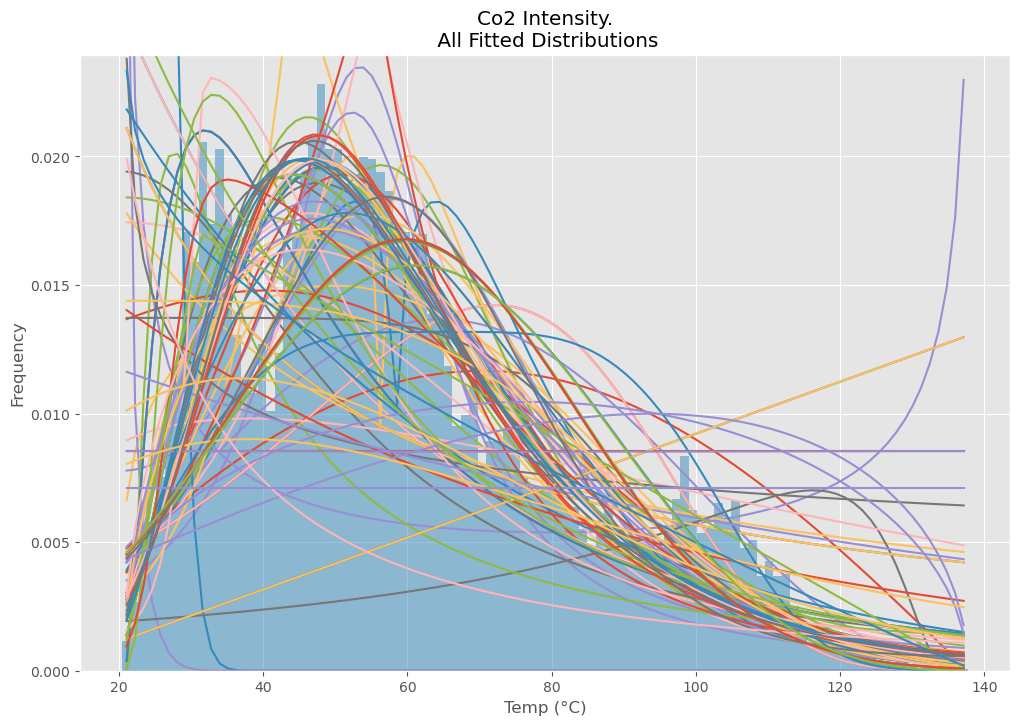

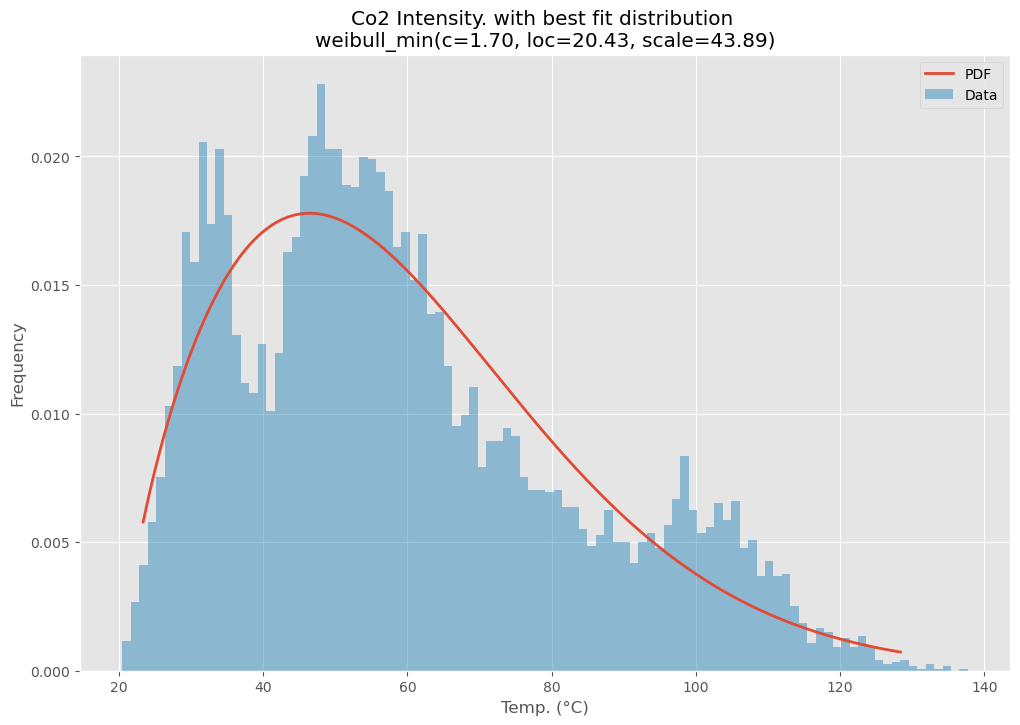

In [ ]:
# Stolen from https://stackoverflow.com/questions/6620471/fitting-empirical-distribution-to-theoretical-ones-with-scipy-python

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
from scipy.stats._continuous_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    def do_fit(task):
        ii, distribution = task
        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')
                
                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]
                
                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))
                
                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    
                except Exception:
                    return False

                # identify if this distribution is better
                return (distribution, params, sse)
        
        except Exception:
            return False


    with ThreadPoolExecutor() as executor:
        best_distributions = list(filter(lambda x: x != False,executor.map(do_fit, enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]))))


    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = co2_intensity["intensity"]

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=100, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 100, ax)


# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Co2 Intensity.\n All Fitted Distributions')
ax.set_xlabel(u'Temp (°C)')
ax.set_ylabel('Frequency')

for i in range (1):

    best_dist = best_distibutions[i]


    # Make PDF with best params 
    pdf = make_pdf(best_dist[0], best_dist[1])

    # Display
    plt.figure(figsize=(12,8))
    ax = pdf.plot(lw=2, label='PDF', legend=True)
    data.plot(kind='hist', bins=100, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

    param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
    dist_str = '{}({})'.format(best_dist[0].name, param_str)

    ax.set_title(u'Co2 Intensity. with best fit distribution \n' + dist_str)
    ax.set_xlabel(u'Temp. (°C)')
    ax.set_ylabel('Frequency')
